# Simulazione Real Environment 

## Drive & Environment Setting

In [2]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi_GDrive
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi_GDrive'
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

from pkl import store_data, load_data
from functions.compressor import compress
from functions.compressor_param import compress_2


import random
from collections import defaultdict

import time



print("Libraries imported")

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
Libraries imported


## Import Anagrafica & CTA

In [3]:
cta30_def_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')
CTA30_def = [cta30_def_path]
  
df_def = pd.read_csv(CTA30_def[0])

cta30_18_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
cta30_19_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
cta30_20_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
CTA30_18 = [cta30_18_path]
CTA30_19 = [cta30_19_path]
CTA30_20 = [cta30_20_path]

df18= pd.read_csv(CTA30_18[0])
df19= pd.read_csv(CTA30_19[0])
df20= pd.read_csv(CTA30_20[0])
df = pd.concat([df18, df19], ignore_index=True)

df['VLV_RAF_FDBK_00'] = df['VLV_RAF_FDBK_00'] / 100
df['VLV_SUR_FDBK_00'] = df['VLV_SUR_FDBK_00'] / 100

scaler = MinMaxScaler()
act_f_m = df.loc[:,'F_M_FDBK_00']
a_f_m_reshaped = np.array(act_f_m).reshape(-1, 1)
a_f_m_scaled = scaler.fit_transform(a_f_m_reshaped)

min_f = np.min(a_f_m_scaled)
max_f = np.max(a_f_m_scaled)

a_raf_df = df['VLV_RAF_FDBK_00'] * 0.5
a_sur_df = df['VLV_SUR_FDBK_00'] * 0.5 + 0.5

a_df = pd.concat([a_raf_df, a_sur_df], ignore_index=True)

pca_df = compress_2(df, 0.93)
print("df18 shape: ", df18.shape)
print("df19 shape: ", df19.shape)
[r,c] = df.shape
print("df shape: ", df.shape)
[r,n_components] = pca_df.shape
print("pca_df shape: ", pca_df.shape)

df18 shape:  (141811, 76)
df19 shape:  (523489, 76)
df shape:  (665300, 76)
pca_df shape:  (665300, 6)


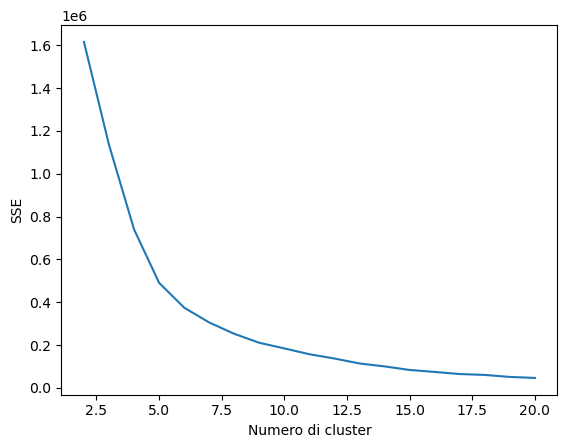

KeyboardInterrupt: 

In [4]:
k_range = range(2, 21)

# Calcoliamo la somma dei quadrati delle distanze intra-cluster per ogni valore di k
X = pca_df
sse = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Visualizziamo la curva del metodo "gomito"
plt.plot(k_range, sse)
plt.xlabel('Numero di cluster')
plt.ylabel('SSE')
plt.show()

In [13]:
n_cluster = 8
kmeans = KMeans(n_clusters=n_cluster, random_state=42)
kms_df_fit = kmeans.fit(X)

kms_df = kmeans.transform(X)

In [32]:
labels = kmeans.labels_
cluster_sizes = pd.Series(labels).value_counts()
print(cluster_sizes)
df['Cluster'] = labels
pca_df['Cluster'] = labels


2    222241
1    177827
3    110769
4     63597
0     32316
7     20890
6     19949
5     17711
dtype: int64


In [44]:
counts = df['F_M_FDBK_00'].value_counts
print(counts)


<bound method IndexOpsMixin.value_counts of 0          99.9998
1         100.0128
2          99.9898
3         100.0072
4          99.9782
            ...   
665295     50.0169
665296     50.0213
665297     50.0296
665298     50.0241
665299     50.0071
Name: F_M_FDBK_00, Length: 665300, dtype: float64>


AttributeError: 'function' object has no attribute 'plt'

In [34]:
# generate a df for each cluster
cluster_dfs = []
for i in range(n_cluster):
    cluster_df = df[df['Cluster'] == i]
    cluster_dfs.append(cluster_df)
    